In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from liualgotrader.common import config
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import pytz
import sys
import iso8601
import asyncio
from pandas import DataFrame as df
from liualgotrader.analytics.analysis import (
    load_trades_by_batch_id,
    calc_batch_revenue,
    count_trades,
)
from liualgotrader.common.market_data import get_historical_data_from_poylgon_for_symbols
import nest_asyncio
nest_asyncio.apply()

In [2]:
batch_id = "022dae2f-d14b-45b1-8040-754500f529d7"

In [3]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")

In [4]:
trades = load_trades_by_batch_id(batch_id)

[2145]2020-10-27 14:48:46.356579:db connection pool initialized


In [5]:
day_to_analyze = min(trades['client_time'].tolist())
config.market_open = day_to_analyze.replace(hour=9, minute=30, second=0, microsecond=0)

In [6]:
how_was_my_batch = pd.DataFrame()
trades["client_time"] = pd.to_datetime(trades["client_time"])
how_was_my_batch["symbol"] = trades.symbol.unique()
how_was_my_batch["revenues"] = how_was_my_batch["symbol"].apply(
    lambda x: calc_batch_revenue(x, trades, batch_id)
)
how_was_my_batch["count"] = how_was_my_batch["symbol"].apply(
    lambda x: count_trades(x, trades, batch_id)
)

In [7]:
pd.set_option('display.max_rows', how_was_my_batch.shape[0]+1)
how_was_my_batch

,symbol,revenues,count
0,AMTX,19.64,2
1,ATNX,-1.70,2
2,AXGT,70.72,2
3,FOSL,65.60,2
4,JMIA,2.22,2
5,PEIX,-103.96,2
6,SSNT,33.85,2
7,WEI,0.00,2
8,WWR,14.46,2


In [8]:
print(f"Revenue: ${round(sum(how_was_my_batch['revenues'].tolist()), 2)}")

Revenue: $100.83


In [9]:

minute_history = get_historical_data_from_poylgon_for_symbols(
    api,
    trades.symbol.unique().tolist(),
    day_to_analyze - timedelta(days=7),
    day_to_analyze + timedelta(days=1),
)

AMTX analysis with profit 19.64


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1998.37,-1998.37,buy,2020-10-26 13:00:00-04:00,4.07,491,4.09%,,"{'avg': 4.178273756789106, 'macd': [-0.0068639768306768545, -0.00884054300143955, -0.010785392705911612, -0.011641309453475301, -0.011538889913220274], 'vwap': 4.064633333333333, 'reason': ['MACD signal'], 'macd_signal': [0.0009602294380414867, -0.0009999250498547206, -0.002957018581066099, -0.00469387675554794, -0.006062879387082406]}",4.89,3.87
1,19.64,2018.01,sell,2020-10-26 14:47:00-04:00,4.11,491,5.12%,,"{'avg': 4.163900930652103, 'rsi': [58.89922960275674, 55.08308048794618, 55.11439945612459], 'vwap': 4.110066666666667, 'reasons': 'bail post whipsawed', 'movement': 0.009381369876470392, 'sell_macd': [0.010503095145992347, 0.010780834027782404, 0.010337762584660126, 0.009338774933075555, 0.008442523408900726], 'sell_macd_signal': [0.009088036009329198, 0.00942659561301984, 0.009608829007347896, 0.009554818192493427, 0.009332359235774888]}",4.89,3.87


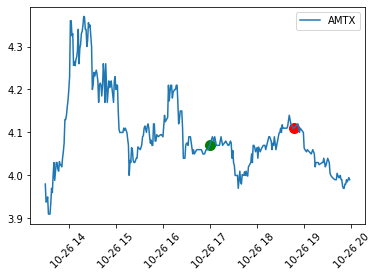

ATNX analysis with profit -1.70


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1989.00,-1989.00,buy,2020-10-26 13:54:00-04:00,11.70,170,0.21%,,"{'avg': 11.733599481683896, 'macd': [-0.01587015403312897, -0.017083920498540905, -0.020145505789791684, -0.02149030594154766, -0.021220146242376003], 'vwap': 11.691666666666668, 'reason': ['MACD signal'], 'macd_signal': [-0.005009579639487373, -0.00742444781129808, -0.0099686594069968, -0.012272988713906972, -0.014062420219600778]}",14.06,11.11
1,-1.70,1987.30,sell,2020-10-26 15:59:00-04:00,11.69,170,0.13%,,{'liquidate': 1},None,None


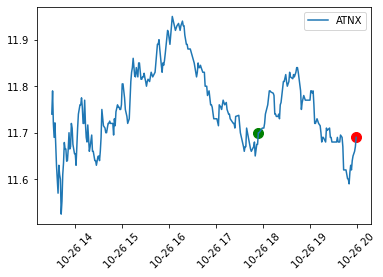

AXGT analysis with profit 70.72


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1996.48,-1996.48,buy,2020-10-26 13:41:00-04:00,3.67,544,2.8%,,"{'avg': 3.7193059759813405, 'macd': [-0.012504642336712557, -0.013779105520411505, -0.015995841695756408, -0.016995949862313786, -0.016255827006874224], 'vwap': 3.6683, 'reason': ['MACD signal'], 'macd_signal': [-0.003911224103605292, -0.005884800386966535, -0.00790700864872451, -0.009724796891442365, -0.011031002914528737]}",4.46,3.49
1,70.72,2067.20,sell,2020-10-26 15:44:00-04:00,3.80,544,6.44%,,"{'avg': 3.7208220570273327, 'rsi': [77.09061620611567, 78.65303801647933, 80.14079372974558], 'vwap': 3.7983999999999996, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.03544959128065398, 'sell_macd': [0.009911554952497514, 0.01044279416437277, 0.01072112609357001, 0.011058512972248469, 0.011354418163787017], 'sell_macd_signal': [0.008106369189059912, 0.008573654184122485, 0.00900314856601199, 0.009414221447259286, 0.009802260790564832]}",4.46,3.49


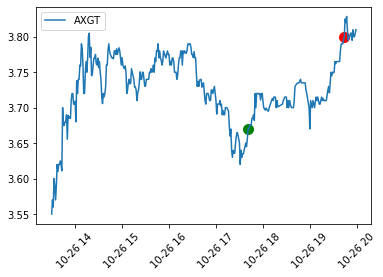

FOSL analysis with profit 65.60


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1994.24,-1994.24,buy,2020-10-26 13:10:00-04:00,6.08,328,1.76%,,"{'avg': 6.312043417884227, 'macd': [-0.03420416421977368, -0.03543664995961837, -0.036196552484696554, -0.03735756026417736, -0.03699785775125086], 'vwap': 6.0767, 'reason': ['MACD signal'], 'macd_signal': [-0.01812702085377068, -0.02158894667494022, -0.024510467836891488, -0.027079886322348663, -0.029063480608129102]}",7.42,5.78
1,65.60,2059.84,sell,2020-10-26 14:26:00-04:00,6.28,328,5.1%,,"{'avg': 6.285387556181171, 'rsi': [66.69108143562286, 66.69108143562286, 69.03688807493073], 'vwap': 6.276666666666666, 'reasons': 'bail', 'movement': 0.03289473684210529, 'sell_macd': [0.02128933584522752, 0.02098760666460553, 0.019960446177567093, 0.018900834808738054, 0.018176018571441688], 'sell_macd_signal': [0.01905144024803333, 0.019438673531347768, 0.019543028060591633, 0.019414589410220916, 0.01916687524246507]}",7.42,5.78


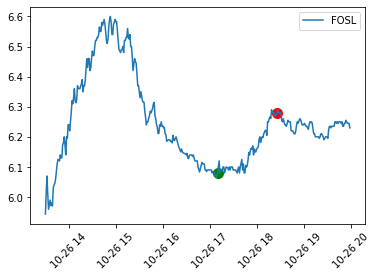

JMIA analysis with profit 2.22


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1992.45,-1992.45,buy,2020-10-26 13:18:00-04:00,17.95,111,-5.65%,,"{'avg': 18.402574956170458, 'macd': [-0.04395203454621921, -0.06781210471729437, -0.07880680738674073, -0.07971687690336182, -0.07957255604743807], 'vwap': 17.959999999999997, 'reason': ['MACD signal'], 'macd_signal': [-0.015403646173388704, -0.02588533788216984, -0.03646963178308402, -0.045119080807139576, -0.052009775855199274]}",21.76,17.05
1,2.22,1994.67,sell,2020-10-26 14:08:00-04:00,17.97,111,-5.55%,,"{'avg': 18.353192513129258, 'rsi': [60.02655383737267, 60.18607080442988, 53.878754290205855], 'vwap': 17.9959, 'reasons': 'bail post whipsawed', 'movement': 0.0013593314763231186, 'sell_macd': [0.04347454238468984, 0.04515115928690605, 0.044572534025164146, 0.04367266324945618, 0.03998350857683519], 'sell_macd_signal': [0.03770143356146709, 0.03919137870655488, 0.040267609770276734, 0.040948620466112626, 0.04075559808825714]}",21.76,17.05


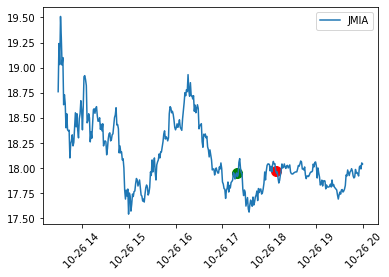

PEIX analysis with profit -103.96


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1995.58,-1995.58,buy,2020-10-26 13:10:00-04:00,8.83,226,2.43%,,"{'avg': 8.878305667017191, 'macd': [-0.038894177250242024, -0.030094662640433256, -0.02430160368940726, -0.02726413432900543, -0.026621117498446978], 'vwap': 8.82, 'reason': ['MACD signal'], 'macd_signal': [-0.02788414676073799, -0.028326249936677043, -0.027521320687223086, -0.027469883415579554, -0.02730013023215304]}",10.60,8.39
1,-103.96,1891.62,sell,2020-10-26 15:08:00-04:00,8.37,226,-2.91%,,"{'avg': 8.806079588151741, 'rsi': [27.606691787191366, 26.637795350393763, 23.9249784325], 'vwap': 8.38, 'reasons': 'stopped', 'movement': -0.05209513023782569, 'sell_macd': [-0.008374110911107735, -0.01183596840861334, -0.016717468167597005, -0.020823604756836644, -0.02479171632303867], 'sell_macd_signal': [-0.0063883422641175264, -0.007477867493016689, -0.009325787627932753, -0.011625351053713531, -0.014258624107578558]}",10.60,8.39


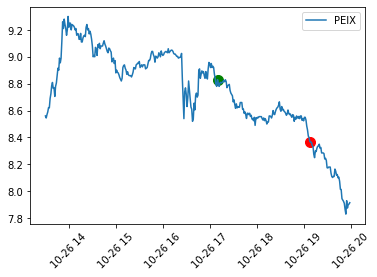

SSNT analysis with profit 33.85


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1997.15,-1997.15,buy,2020-10-26 13:51:00-04:00,2.95,677,4.98%,,"{'avg': 3.1246204214580677, 'macd': [-0.020127866238881076, -0.024652641678196918, -0.026819315505219432, -0.027899589714519557, -0.02759980871248713], 'vwap': 2.9500000000000006, 'reason': ['MACD signal'], 'macd_signal': [0.006077530770964253, -6.850371886798177e-05, -0.005418666076138272, -0.009914850803814528, -0.013451842385549048]}",3.54,2.80
1,33.85,2031.00,sell,2020-10-26 14:37:00-04:00,3.00,677,6.76%,,"{'avg': 3.116978412098575, 'rsi': [58.429905403642536, 56.0655054096778, 54.03552504913588], 'vwap': 3.0, 'reasons': 'bail', 'movement': 0.01694915254237282, 'sell_macd': [0.017752989103830608, 0.016388195770415503, 0.01623396465645044, 0.015300356455225206, 0.013854683097708875], 'sell_macd_signal': [0.013497568011369037, 0.01407569356317833, 0.014507347781832752, 0.014665949516511243, 0.01450369623275077]}",3.54,2.80


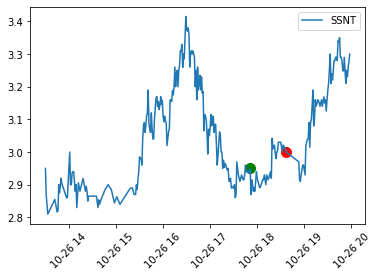

WEI analysis with profit 0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1999.88,-1999.88,buy,2020-10-26 13:20:00-04:00,1.73,1156,-2.81%,,"{'avg': 1.9029095341492048, 'macd': [-0.022617699485056875, -0.025896336876234827, -0.028104413585253507, -0.028888571883381564, -0.02865689559772333], 'vwap': 1.7266666666666666, 'reason': ['MACD signal'], 'macd_signal': [-0.01104812600061383, -0.01401776817573803, -0.016835097257641124, -0.019245792182789212, -0.021128012865776036]}",2.15,1.64
1,0.00,1999.88,sell,2020-10-26 13:47:00-04:00,1.73,1156,-2.81%,,"{'avg': 1.8985336098356014, 'rsi': [48.387431898415166, 48.34591626047282, 44.256676084072275], 'vwap': 1.7366666666666666, 'reasons': 'bail', 'movement': 0.0, 'sell_macd': [0.0036377952499762056, 0.003439322980224979, 0.0027257170170391642, 0.0021290666948547976, 0.0014633339759035913], 'sell_macd_signal': [0.00186708680913223, 0.0021815340433507797, 0.0022903706380884565, 0.0022581098494417248, 0.0020991546747340982]}",2.15,1.64


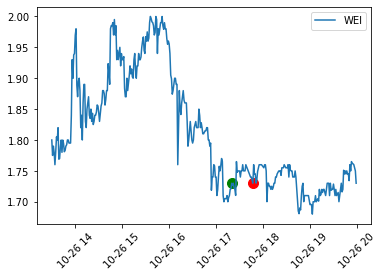

WWR analysis with profit 14.46


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2000.30,-2000.30,buy,2020-10-26 13:17:00-04:00,4.15,482,4.81%,,"{'avg': 4.361856815876527, 'macd': [-0.010998370364235122, -0.016006872448043552, -0.01970171988415359, -0.023363916329380174, -0.02284401854216167], 'vwap': 4.141466666666666, 'reason': ['MACD signal'], 'macd_signal': [0.001717476544734196, -0.0018273932538213542, -0.005402258579887802, -0.008994590129786276, -0.011764475812261355]}",5.02,3.94
1,14.46,2014.76,sell,2020-10-26 14:12:00-04:00,4.18,482,5.57%,,"{'avg': 4.354121325794144, 'rsi': [67.09370877191736, 56.868791605230115, 46.34258098881523], 'vwap': 4.206666666666666, 'reasons': 'bail', 'movement': 0.007447398230941633, 'sell_macd': [0.014286152439979105, 0.015594179221738003, 0.016738171789060452, 0.015531696233868963, 0.013172559053626465], 'sell_macd_signal': [0.013423741928470291, 0.013857829387123833, 0.014433897867511158, 0.014653457540782719, 0.014357277843351468]}",5.02,3.94


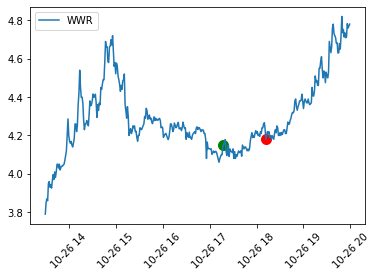

In [10]:
for symbol in minute_history:
    symbol_df = trades.loc[trades["symbol"] == symbol]
    start_date = symbol_df["client_time"].min()
    start_date = start_date.replace(hour=9, minute=30)
    end_date = start_date.replace(hour=16, minute=0)
    cool_down_date = start_date + timedelta(minutes=5)
    minute_history_index = minute_history[symbol]["close"].index.get_loc(
        start_date, method="nearest"
    )
    end_index = minute_history[symbol]["close"].index.get_loc(
        end_date, method="nearest"
    )
    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(
        cool_down_date, method="nearest"
    )
    open_price = minute_history[symbol]["close"][cool_minute_history_index]
    plt.plot(
        minute_history[symbol]["close"][minute_history_index:end_index].between_time(
            "9:30", "16:00"
        ),
        label=symbol,
    )
    plt.xticks(rotation=45)

    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    daily_change = []
    precent_vwap = []
    patterns = []
    for index, row in symbol_df.iterrows():
        if (
            row["operation"] == "buy"
            and row["qty"] > 0
            or row["operation"] == "sell"
            and row["qty"] < 0
        ):
            try:
                now = int(row["client_time"])
                continue
            except Exception:
                pass

        delta = (
            row["price"]
            * row["qty"]
            * (1 if row["operation"] == "sell" and row["qty"] > 0 else -1)
        )
        profit += delta
        plt.scatter(
            row["client_time"].to_pydatetime(),
            row["price"],
            c="g" if row["operation"] == "buy" else "r",
            s=100,
        )
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row["operation"])
        times.append(pd.to_datetime(row["client_time"]))
        prices.append(row["price"])
        qtys.append(row["qty"])
        indicator = json.loads(row.indicators)
        indicators.append(indicator)
        target_price.append(row["target_price"])
        stop_price.append(row["stop_price"])
        daily_change.append(
            f"{round(100.0 * (float(row['price']) - open_price) / open_price, 2)}%"
        )
        precent_vwap.append(
            f"{round(100.0 * (indicator['buy']['avg'] - open_price) / open_price, 2)}%"
            if 'buy' in indicator and indicator['buy'] and "avg" in indicator['buy']
            else ""
        )

    d = {
        "profit": profits,
        "trade": deltas,
        "operation": operations,
        "at": times,
        "price": prices,
        "qty": qtys,
        "daily change": daily_change,
        "vwap": precent_vwap,
        "indicators": indicators,
        "target price": target_price,
        "stop price": stop_price,
    }
    print(f"{symbol} analysis with profit {round(profit, 2)}")
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()